# Parabolske koordinater

Parabolske koordinater $(u, v)$ er gitt ved posisjonsvektor

$$
\vec{r} = 2 u v \mathbf{i} + (u^2-v^2)\mathbf{j}
$$

1. Finn enhetsvektorne. Er de ortogonale?
2. Finn gradienten til skalarfelt $f(u, v) = (1-u^2)(1-v^2)$ representert med parabolske koordinater. Plott skalarfeltet med tilhørende gradient for $(u, v) \in [0, 1] \times [-1, 1]$. Bruk Kartesiske koordinater til plottingen.

Start med å importere funksjonalitet fra `sympy`, og lag to tupler (Python immutable list) for `psi=(u, v)` og `rv=(2uv, u**2-v**2)` 

In [1]:
import sympy as sp
import numpy as np
u, v = psi = sp.symbols('u,v', real=True)
rv = (2*u*v, u**2-v**2)

Finn enhetsvektorer og skaleringsfaktorer. Lager to generelle funksjoner som kan gjenbrukes for andre koordinater

In [2]:
def basisvektorer(psi, rv):
    """Returner basisvektorer
    
    Parameters
    ----------
    psi : Tuple av nye variable
    rv : Posisjonsvektor
    """
    b = np.zeros((len(psi), len(rv)), dtype=object)
    for i, ui in enumerate(psi):
        for j, rj in enumerate(rv):
            b[i, j] = sp.simplify(rj.diff(ui, 1))
    return b

def skaleringsfaktorer(b):
    """Returner skaleringsfaktorer
    
    Parameters
    ----------
    b : basisvektorer
    """
    h = np.zeros(b.shape[0], dtype=object)
    for i, s in enumerate(np.sum(b**2, axis=1)):
        h[i] = sp.simplify(sp.sqrt(s))
    return h

def enhetsvektorer(psi, rv):
    """Returner enhetsvektorer og skaleringsfaktorer
    
    Parameters
    ----------
    psi : Tuple av nye variable
    rv : Posisjonsvektor
    """
    b = basisvektorer(psi, rv)
    hi = skaleringsfaktorer(b)
    return b / hi[None, :], hi

In [3]:
e, hi = enhetsvektorer(psi, rv)

Skriv ut enhetsvektorer og sjekk at de stemmer med Vector Calculus example 6.2. 

In [4]:
print(e)
print(hi)

[[v/sqrt(u**2 + v**2) u/sqrt(u**2 + v**2)]
 [u/sqrt(u**2 + v**2) -v/sqrt(u**2 + v**2)]]
[2*sqrt(u**2 + v**2) 2*sqrt(u**2 + v**2)]


Lag skalarfelt $f(u, v) = (1-u^2)(1-v^2)$

In [5]:
f = (1-u**2)*(1-v**2)

Plott skalarfelt. Merk at vi bruker $x=2uv$ og $y=u^2-v^2$ evaluert på et strukturert grid. `sp.lambdify` er en effektiv (vektorisert) metode å evaluere en `sympy` funksjon på. Så under tilsvarer `f(u, v) = sp.lambdify((u, v), f)(ui, vi)`.

In [6]:
N = 20
ui = np.broadcast_to(np.linspace(0, 1, N)[:, None], (N, N))
vi = np.broadcast_to(np.linspace(-1, 1, N)[None, :], (N, N))
fj = sp.lambdify((u, v), f)(ui, vi)

Hvis vi nå velger å plotte $f(u, v)$ i det nye koordinatsystemet får vi.

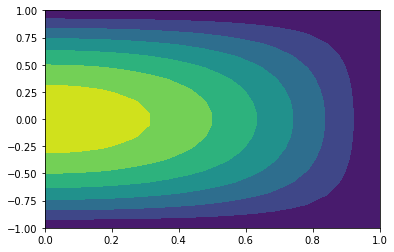

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.contourf(ui, vi, fj)

Men det er kanskje mer interessant å se resultatet i fysiske (Kartesiske) koordinater. Vi trenger derfor å finne kartesiske `x, y` fra de gitte `u, v`. Gjør dette som følger

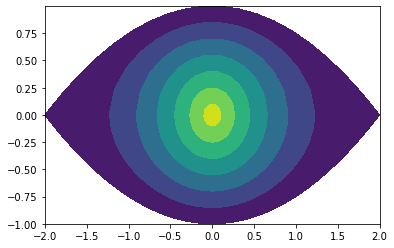

In [8]:
mesh = []
for rj in rv:
    mesh.append(sp.lambdify((u, v), rj)(ui, vi))
x, y = mesh

plt.contourf(x, y, fj)

Å plotte gradienten i Kartesiske koordinater er mer involvert siden vi har beregnet gradienten i de nye koordinatene og derfor trenger å projisere ved å ta prikk-produktet av gradientvektoren

$$
\begin{align}
\frac{\partial f}{\partial x} &= \nabla f \cdot \mathbf{i},\\
\frac{\partial f}{\partial y} &= \nabla f \cdot \mathbf{j}.
\end{align}
$$

For å finne gradientvektoren deriverer vi først for å finne komponentene til $\nabla f$ i nye koordinater

In [9]:
df = np.array((1/hi[0]*f.diff(u, 1), 1/hi[1]*f.diff(v, 1)))
print(df)

[-u*(1 - v**2)/sqrt(u**2 + v**2) -v*(1 - u**2)/sqrt(u**2 + v**2)]


Merk at `df` nå ikke inneholder enhetsvektorer. Så før vi prikker med $\mathbf{i}$ og $\mathbf{j}$ må vi gange med enhetsvektorene $\mathbf{e_1}$ og $\mathbf{e_2}$ for å få $\nabla f$

$$
\nabla f = \frac{\mathbf{e}_1}{h_1}\frac{\partial f}{\partial u} + \frac{\mathbf{e}_2}{h_2}\frac{\partial f}{\partial v},
$$

In [10]:
gradf = e[0]*df[0] + e[1]*df[1]
print(gradf)

[-u*v*(1 - u**2)/(u**2 + v**2) - u*v*(1 - v**2)/(u**2 + v**2)
 -u**2*(1 - v**2)/(u**2 + v**2) + v**2*(1 - u**2)/(u**2 + v**2)]


Merk at vi med denne summen nå har fått satt inn for $\mathbf{e_1}$ og $\mathbf{e_2}$, så vektoren `gradf` over er allerede gitt ved Kartesiske enhetsvektorer (e.g., siden $\mathbf{e_1} = 2/h_1(v\mathbf{i} + u\mathbf{j})$). Ved prikking mot $\mathbf{i}$ er resultatet derfor `gradf[0]`, mens prikking mot $\mathbf{j}$ gir `gradf[1]`. Derfor skipper vi prikkproduktet og henter ganske enkelt de Kartesiske vektorkomponentene

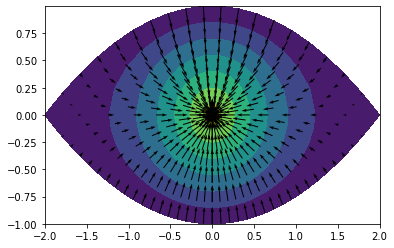

In [11]:
dfdxi = sp.lambdify((u, v), gradf[0])(ui, vi)
dfdyi = sp.lambdify((u, v), gradf[1])(ui, vi)
plt.contourf(x, y, fj)
plt.quiver(x, y, dfdxi, dfdyi, scale=20)

Merk at gradienten peker i retning av økende $f$.